In [1]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch
import json

# the json file where the output must be stored
json_file = open("imagenet_labels.json", "r")
imagenet_dict = json.load(json_file)
json_file.close()

def predict(model, img):
    output = model(img)
    top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)
    return top5_probabilities, top5_class_indices.tolist()[0]

def preprocess_data(img):
    # unsqueeze single image into batch of 1.
    return transforms(img).unsqueeze(0)

def idx_to_label(idx):
    if isinstance(idx, list):
        return [idx_to_label(i) for i in idx]
    else:
        return imagenet_dict.get(str(idx))

In [2]:
img = Image.open(urlopen(
    'https://unsplash.com/photos/DwxlhTvC16Q/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8MXx8bWVyY2VkZXMlMjBjYXJ8ZW58MHx8fHwxNjg2NzA1MzUyfDA&force=true&w=640'
))

model = timm.create_model('vgg16.tv_in1k', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

In [3]:
probs, labels = predict(model, preprocess_data(img))
idx_to_label(labels)

['sports car, sport car',
 'racer, race car, racing car',
 'car wheel',
 'convertible',
 'pickup, pickup truck']

In [18]:
import pyRAPL

# Using model on GPU

pyRAPL.setup()
meter_preprocessing = pyRAPL.Measurement('GPU test - Preprocessing')
meter_prediction = pyRAPL.Measurement('GPU test - Prediction')

meter_preprocessing.begin()
for _ in range(100):
    p_img = preprocess_data(img)
meter_preprocessing.end()
meter_prediction.begin()
for _ in range(100):
    probs, labels = predict(model.cuda(), p_img.cuda())
meter_prediction.end()

In [19]:
# CPU

pyRAPL.setup()
meter_cpu_preprocessing = pyRAPL.Measurement('CPU test - Preprocessing')
meter_cpu_prediction = pyRAPL.Measurement('CPU test - Prediction')

meter_cpu_preprocessing.begin()
for _ in range(100):
    p_img = preprocess_data(img)
meter_cpu_preprocessing.end()
meter_cpu_prediction.begin()
for _ in range(100):
    probs, labels = predict(model.cpu(), p_img.cpu())
meter_cpu_prediction.end()

In [31]:
from datetime import datetime
import numpy as np
import pandas as pd

def get_total_jules_disk(filename, meter):
    # Disk in LSD15 has an avg i/o speed of 1600MB/s and a power consumption of 6W when active and 1.42W when idle.
    avg_speed_bytes = 1600*1e6
    active_power = 6
    idle_power = 1.42
    
    df = pd.read_csv(filename, skiprows=[0], sep=";")
    df.index = pd.to_datetime(df.index)
    filtered_df = df[(df.index >= datetime.fromtimestamp(meter.result.timestamp)) & 
            (df.index < datetime.fromtimestamp(meter.result.timestamp + meter.result.duration*1e-6))]
    # TODO: headers are wrongly read by pandas, fix this.
    tot_bytes = filtered_df[filtered_df["ByteSize"].str.contains("python")]["Operation"].sum()
    # energy = (tot_bytes / avg_speed) * active_power + idle_time * idle_power
    return (tot_bytes / avg_speed_bytes) * 6 + idle_power * meter.result.duration*1e-6 - (tot_bytes / avg_speed_bytes)

def get_total_jules_gpu(filename, meter):
    df = pd.read_csv(filename)
    df.timestamp = pd.to_datetime(df.timestamp)
    mean_p = df[(df.timestamp >= datetime.fromtimestamp(meter.result.timestamp)) & 
        (df.timestamp < datetime.fromtimestamp(meter.result.timestamp + meter.result.duration*1e-6))]["power_usage(W)"].mean()
    return mean_p*meter.result.duration*1e-6

def get_total_jules_per_component(foldername, meter):
    pkg = np.array(meter.result.pkg)*1e-6
    dram = np.array(meter.result.dram)*1e-6
    gpu = get_total_jules_gpu(foldername + "/gpu_stats.csv", meter)
    if np.isnan(gpu):
        gpu = 0
    disk = get_total_jules_disk(foldername + "/disk_stats.csv", meter)
    res = { "total": np.sum(pkg) + np.sum(dram) + disk + gpu,
            "pkg": pkg,
            "dram": dram,
            "gpu": gpu,
            "disk": disk,
          }
    return res

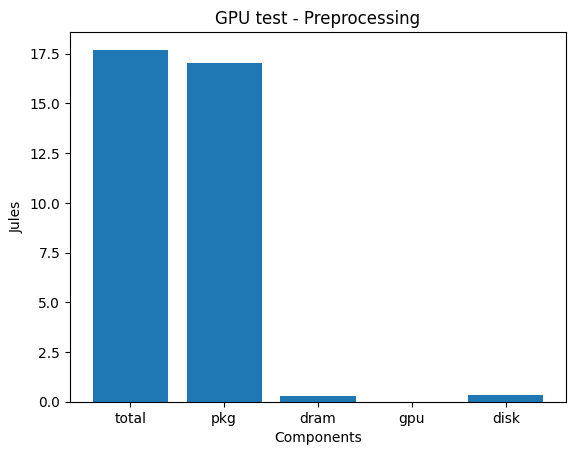

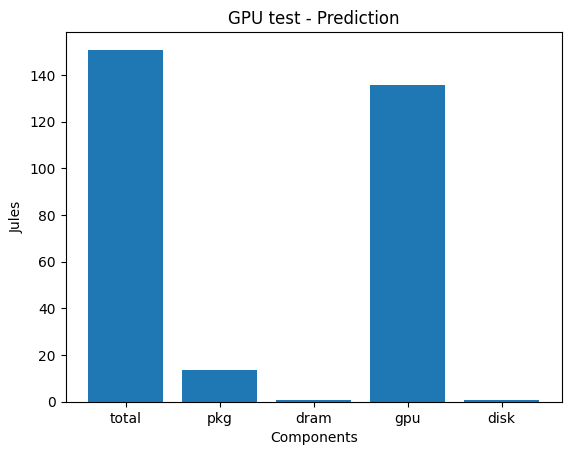

In [32]:
import matplotlib.pyplot as plt

def plot_total_jules_per_component(foldername, meter):
    data = get_total_jules_per_component(foldername, meter)
    keys = data.keys()
    values = [float(val) for val in data.values()]
    
    plt.bar(keys, values)
    plt.xlabel('Components')
    plt.ylabel('Jules')
    plt.title(meter.label)
    
    plt.show()

plot_total_jules_per_component("meter_2023-06-15 22:54:53", meter_preprocessing)
plot_total_jules_per_component("meter_2023-06-15 22:54:53", meter_prediction)

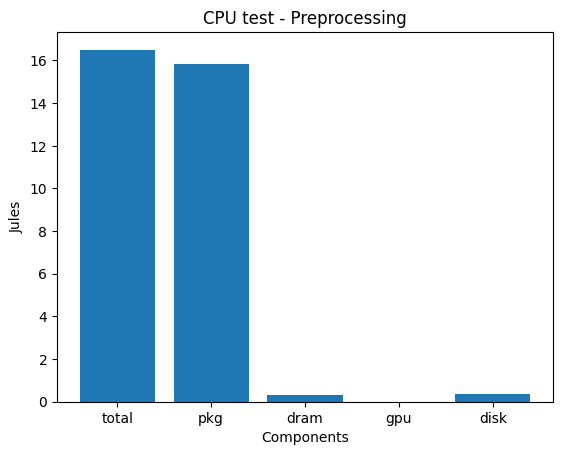

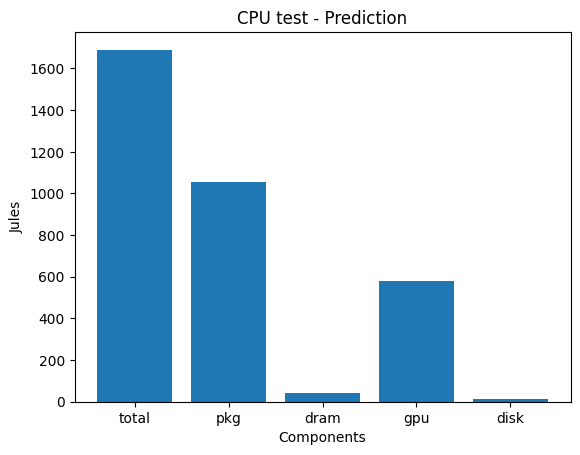

In [33]:
plot_total_jules_per_component("meter_2023-06-15 22:54:53", meter_cpu_preprocessing)
plot_total_jules_per_component("meter_2023-06-15 22:54:53", meter_cpu_prediction)